In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

In [12]:
df= pd.read_csv('MBA.csv')
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [13]:
df= df.drop('application_id', axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         6194 non-null   object 
 1   international  6194 non-null   bool   
 2   gpa            6194 non-null   float64
 3   major          6194 non-null   object 
 4   race           4352 non-null   object 
 5   gmat           6194 non-null   float64
 6   work_exp       6194 non-null   float64
 7   work_industry  6194 non-null   object 
 8   admission      1000 non-null   object 
dtypes: bool(1), float64(3), object(5)
memory usage: 393.3+ KB


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gpa,6194.0,3.250714,0.151541,2.65,3.15,3.25,3.35,3.77
gmat,6194.0,651.092993,49.294883,570.00,610.00,650.00,680.00,780.00
work_exp,6194.0,5.016952,1.032432,1.00,4.00,5.00,6.00,9.00


In [16]:
#GET CATEGORICAL COLUMNS ONLY
categorical_cols = df.select_dtypes(include=['object','category'])
    
#LIST OF UNIQUE VALUES IN EACH CATEGORICAL COLUMN

for col in categorical_cols.columns:
        print(f"Unique values in {col }:{ categorical_cols[col].unique() }")

Unique values in gender:['Female' 'Male']
Unique values in major:['Business' 'Humanities' 'STEM']
Unique values in race:['Asian' 'Black' nan 'Hispanic' 'White' 'Other']
Unique values in work_industry:['Financial Services' 'Investment Management' 'Technology' 'Consulting'
 'Nonprofit/Gov' 'PE/VC' 'Health Care' 'Investment Banking' 'Other'
 'Retail' 'Energy' 'CPG' 'Real Estate' 'Media/Entertainment']
Unique values in admission:['Admit' nan 'Waitlist']


In [17]:
df['admission'].value_counts

<bound method IndexOpsMixin.value_counts of 0       Admit
1         NaN
2       Admit
3         NaN
4         NaN
        ...  
6189      NaN
6190      NaN
6191    Admit
6192      NaN
6193      NaN
Name: admission, Length: 6194, dtype: object>

label counts:
admission
Admit       90.0
Waitlist    10.0
Name: proportion, dtype: float64


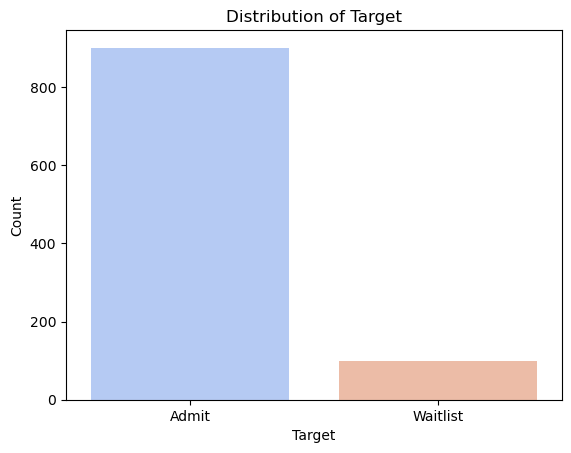

In [18]:
#Study the distribution of target variable
distribution= df['admission'].value_counts(normalize=True)*100
#Calculate y-the percentage distribution of the target variable
distribution_percentage = df['admission'].value_counts(normalize=True)*100

print(f'label counts:\n{distribution_percentage}')

#Plot the distribution of the quality variable
sns.countplot(x='admission', data=df, palette='coolwarm')
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

## 2. Data Prepartion

In [19]:
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [20]:
#Gender 0,1 
#Map 'Male' to 0, 'female' to 1
df['gender']=df['gender'].map({'Male':0, 'Female':1})

print(df.head())

   gender  international   gpa       major      race   gmat  work_exp  \
0       1          False  3.30    Business     Asian  620.0       3.0   
1       0          False  3.28  Humanities     Black  680.0       5.0   
2       1           True  3.30    Business       NaN  710.0       5.0   
3       0          False  3.47        STEM     Black  690.0       6.0   
4       0          False  3.35        STEM  Hispanic  590.0       5.0   

           work_industry admission  
0     Financial Services     Admit  
1  Investment Management       NaN  
2             Technology     Admit  
3             Technology       NaN  
4             Consulting       NaN  


In [21]:
#Remove waitlist instances

df= df[df['admission'] != 'Waitlist']

#Map to admit to 1 and null values to 0

df['admission']=df['admission'].map({'Admit':1}).fillna(0)

df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,False,3.30,Business,Asian,620.0,3.0,Financial Services,1.0
1,0,False,3.28,Humanities,Black,680.0,5.0,Investment Management,0.0
2,1,True,3.30,Business,NaN,710.0,5.0,Technology,1.0
3,0,False,3.47,STEM,Black,690.0,6.0,Technology,0.0
4,0,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,0.0


In [22]:
#Separate majority and minority classes 
df_majority = df[df['admission']==0]
df_minority = df[df['admission']==1]

#Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,
                                 n_samples=len(df_minority),
                                 random_state=42)

#Combine minority class with downsampled majority class
df_balanced =pd.concat([df_majority_downsampled, df_minority])

#Suffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#verify class distribution 
print(df_balanced['admission'].value_counts())
df_balanced.head()

admission
1.0    900
0.0    900
Name: count, dtype: int64


,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,0,False,3.25,Humanities,White,670.0,6.0,Nonprofit/Gov,1.0
1,0,False,3.34,Humanities,White,700.0,4.0,Consulting,1.0
2,1,False,3.20,STEM,White,680.0,6.0,Nonprofit/Gov,0.0
3,0,True,3.18,Business,NaN,580.0,6.0,Consulting,0.0
4,0,False,3.33,Humanities,Asian,670.0,5.0,Financial Services,1.0


In [23]:
#Select features and target variable
x= df_balanced.drop('admission', axis=1)
x= pd.get_dummies(x, drop_first = True)
y= df_balanced['admission']

In [24]:
#Split data into training and testing sets
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.3, random_state=42)

# MODELLING

In [25]:
#creating and train the decision three model
clf= DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)

#Make predictions on the test set
y_pred= clf.predict(x_test)
y_prob= clf.predict_proba(x_test)[:, 1]


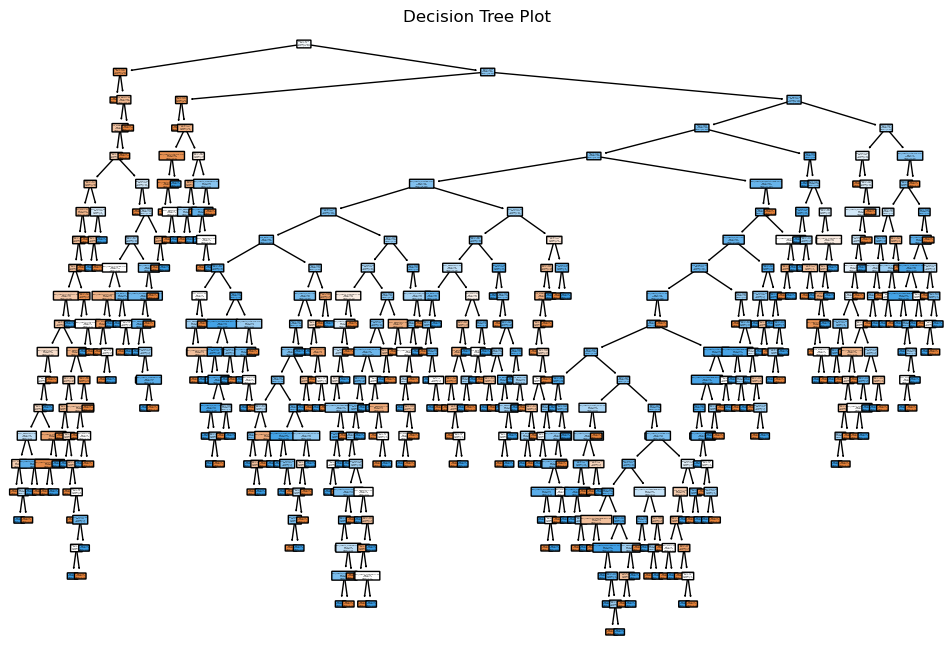

In [26]:
#Plot the decision three using plot_tree
plt.figure(figsize=(12,8))
plot_tree(clf, filled=True, rounded=True,feature_names = list(x_train.columns) , class_names=['Decline', 'Admit'],)
plt.title('Decision Tree Plot')
plt.show()

###EVALUATION

Accuracy: 0.70
Classification Resport:
              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72       287
         1.0       0.69      0.65      0.67       253

    accuracy                           0.70       540
   macro avg       0.70      0.69      0.69       540
weighted avg       0.70      0.70      0.70       540

AUC-ROC:0.69


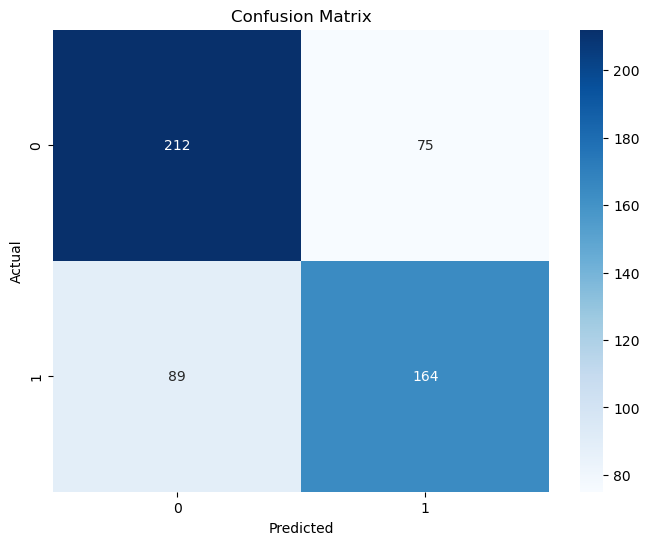

In [27]:
#Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

#Output the results
print(f"Accuracy: {accuracy:.2f}")
print ("Classification Resport:")
print(class_report)
print(f"AUC-ROC:{roc_auc:.2f}")

#Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()